In [1]:
import os
import polars as pl

df = pl.read_csv("./features_complete_shape.csv")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

with open("black_list.txt") as f:
    all = f.read()
    lines = all.split("\n")

for line in lines:
    filter_name = f"dance_data_{line}_corrected"
    print(f"filtering: {filter_name}")
    df = df.filter(
        pl.col("name") != filter_name
    )

name_df = df.clone()
df = df.select(
    pl.exclude("name")
)

df = pl.DataFrame(scaler.fit_transform(df))
data = df.to_numpy()
print(df)
print(df.std())
print(df.mean())

# weight
# df = df.with_columns(
#     column_74 = pl.col("column_74") * 3,
#     column_75 = pl.col("column_75") * 3,
# )

print(df)
print(df.std())
print(df.mean())


filtering: dance_data_141_corrected
filtering: dance_data_25_corrected
filtering: dance_data_98_corrected
filtering: dance_data_99_corrected
filtering: dance_data_100_corrected
filtering: dance_data_118_corrected
filtering: dance_data_129_corrected
filtering: dance_data_48_corrected
filtering: dance_data_49_corrected
filtering: dance_data_34_corrected
shape: (204, 81)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ column_0  ┆ column_1  ┆ column_2  ┆ column_3  ┆ … ┆ column_77 ┆ column_78 ┆ column_79 ┆ column_8 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ 0        │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.26118  ┆ -0.92435 

[[1.00000000e+01 1.87000000e+02 1.74871819e-01 2.00000000e+00]
 [3.80000000e+01 7.70000000e+01 3.06104268e-01 2.00000000e+00]
 [1.43000000e+02 2.05000000e+02 3.91217151e-01 3.00000000e+00]
 [2.04000000e+02 2.06000000e+02 4.75149290e-01 5.00000000e+00]
 [1.77000000e+02 1.94000000e+02 5.78155408e-01 2.00000000e+00]
 [5.70000000e+01 1.49000000e+02 1.03512687e+00 2.00000000e+00]
 [1.31000000e+02 1.54000000e+02 1.37054996e+00 2.00000000e+00]
 [2.07000000e+02 2.08000000e+02 1.59256884e+00 7.00000000e+00]
 [2.50000000e+01 7.30000000e+01 1.71180106e+00 2.00000000e+00]
 [2.80000000e+01 1.96000000e+02 2.15236171e+00 2.00000000e+00]
 [6.20000000e+01 1.36000000e+02 2.17881728e+00 2.00000000e+00]
 [9.00000000e+01 1.82000000e+02 2.35215453e+00 2.00000000e+00]
 [2.12000000e+02 2.13000000e+02 2.79278757e+00 4.00000000e+00]
 [1.64000000e+02 1.88000000e+02 3.43014196e+00 2.00000000e+00]
 [1.14000000e+02 2.14000000e+02 3.45378207e+00 3.00000000e+00]
 [5.60000000e+01 8.90000000e+01 3.45394184e+00 2.000000

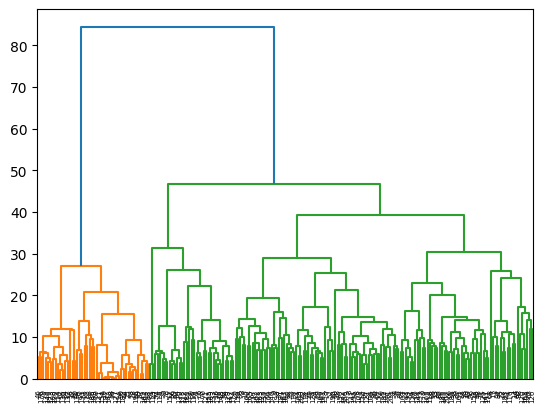

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# display with scipy
linkage_data = linkage(data, method='ward', metric='euclidean')
dendrogram(linkage_data)
print(linkage_data)
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

save_dir = "clustering_data7"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
clustering_generate = [8, 10, 12]
for n in clustering_generate:
    hierarchical_cluster = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = hierarchical_cluster.fit_predict(data)
    cluster_dict = {"cluster": labels}
    out_df = name_df.hstack(pl.from_dict(cluster_dict))
    out_df = out_df.select(
        pl.col("name"),
        pl.col("cluster"),
    ).sort(pl.col("cluster"), pl.col("name"))
    full_save_path = os.path.join(save_dir, f"laban-hierarchial-{n}n-new.csv")
    out_df.write_csv(full_save_path)

    combined_df = name_df.join(
        out_df,
        on=["name"],
        how="inner"
    )

    cluster_center_df = pl.DataFrame()
    clusters = pl.from_dict(cluster_dict)["cluster"].unique().to_list()
    for cluster in clusters:
        cluster_df = combined_df.filter(
            pl.col("cluster") == cluster
        ).drop(
            pl.col("cluster")
        )
        cluster_means = cluster_df.drop("name").mean().to_numpy()
        cluster_min, cluster_min_name = 10000000000000000, ""
        for row in cluster_df.rows():
            name = row[-1]
            row_data = row[:-1]
            row_np = np.array(row_data)
            diff = cluster_means - row_np
            dmean = diff.mean()
            if dmean < cluster_min:
                cluster_min_name = name
                cluster_min = dmean
        cluster_center_dict = {"name": cluster_min_name, "cluster": cluster}
        cluster_df = pl.from_dict(cluster_center_dict)
        cluster_center_df = cluster_center_df.vstack(cluster_df)
    full_save_path = os.path.join(save_dir, f"cluster-centers-hierarchial-{n}n-new.csv")
    cluster_center_df.write_csv(full_save_path)


# n_components = 3
# pca = PCA(n_components=n_components)
# X_pca = pca.fit_transform(data) 
# names = name_df["name"].to_list()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(X_pca[:, 2], X_pca[:, 1], X_pca[:, 0], c=labels, cmap=plt.cm.rainbow)

# plt.title("PCA Visualization")
# plt.tight_layout()
# plt.show()

In [4]:
import concat_videos  

for n in clustering_generate:
    cluster_all_file = f"laban-hierarchial-{n}n-new.csv"
    cluster_centroids_file = f"cluster-centers-hierarchial-{n}n-new.csv"
    input_all_path = os.path.join(save_dir, cluster_all_file)
    input_centroids_path = os.path.join(save_dir, cluster_centroids_file)

    output_all_file = f"laban-hierarchial-{n}n-video-new.mp4"
    output_centroids_file = f"cluster-centers-hierarchial-{n}n-video-new.mp4"
    output_all_path = os.path.join(save_dir, output_all_file)
    output_centroids_path = os.path.join(save_dir, output_centroids_file)

    # remove all tmp files
    import glob
    for f in glob.glob(".tmp*"):
        os.remove(f)

    # generate all
    if os.path.exists(output_all_path):
        os.remove(output_all_path)
    concat_videos.main("./new_clips-out", input_all_path, output_all_path)

    # generate centroids
    if os.path.exists(output_centroids_file):
        os.remove(output_centroids_file)
    concat_videos.main("./new_clips-out", input_centroids_path, output_centroids_path)

ffmpeg version n7.0.2 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.1 (GCC) 20240910
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enabl